# 4 site code generator with U=25 and mu=40 

In [1]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = -5.0, 40.0, 0.1


U_min, U_max, dU = 0.0, 25.0, 1.0   # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 40.0, 0.2
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min/4, U_max/4, dU,mu_min/4,  mu_max/4, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  


✅ Saved results to 4site_phase_tx1.0_U(0.0-6.2)-(1.0)_Mu(-1.2-10.0)-(0.2).csv and 4site_phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(-5.0-40.0)-(0.2).npz


[Parallel(n_jobs=-1)]: Done 5850 out of 5850 | elapsed:  5.6min finished


# Plot of U<=25 and mu<=40


['headers', 'data']
    tx    U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  0.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  0.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  0.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  0.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  0.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     44  
3  0.0     61  
4  0.0    109  
     U   mu  Phase
0  0.0 -5.0      0
1  0.0 -4.8      0
2  0.0 -4.6      0
3  0.0 -4.4      0
4  0.0 -4.2      0


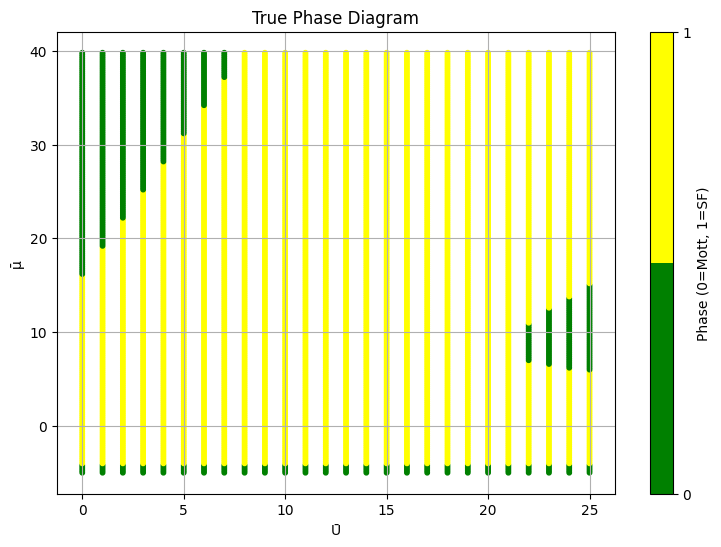

In [5]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(-5.0-40.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(0.0-6.2)-(1.0)_Mu(-1.2-10.0)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# dataset with 20<U<80 and mu<=40 

In [9]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = 0.0, 50.0, 0.1


U_min, U_max, dU = 20.0, 80.0, 1.0   # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 100.0, 0.2
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min/4, U_max/4, dU,mu_min/4,  mu_max/4, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  


✅ Saved results to 4site_phase_tx1.0_U(5.0-20.0)-(1.0)_Mu(-1.2-25.0)-(0.2).csv and 4site_phase_tx1.0_U(20.0-80.0)-(1.0)_Mu(-5.0-100.0)-(0.2).npz


['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  20.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  20.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  20.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  20.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  20.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  20.0 -5.0      0
1  20.0 -4.8      0
2  20.0 -4.6      0
3  20.0 -4.4      0
4  20.0 -4.2      0


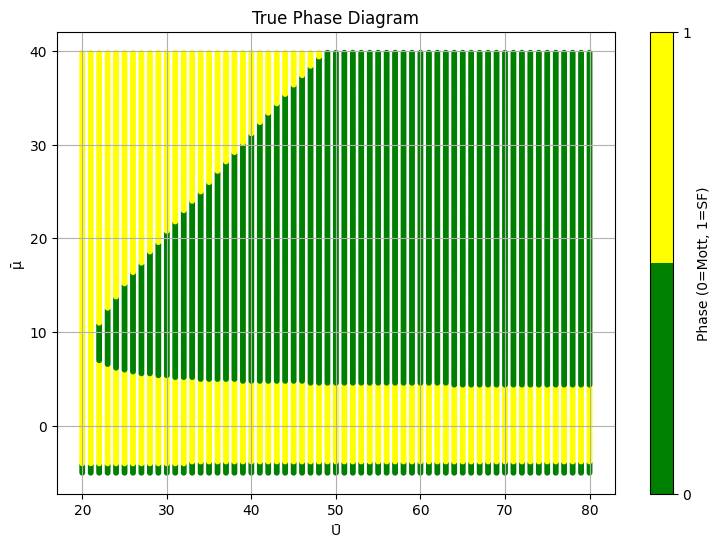

In [8]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(20.0-80.0)-(1.0)_Mu(-5.0-40.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(5.0-20.0)-(1.0)_Mu(-1.2-10.0)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# U<80 and mu<=100

['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  20.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  20.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  20.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  20.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  20.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  20.0 -5.0      0
1  20.0 -4.8      0
2  20.0 -4.6      0
3  20.0 -4.4      0
4  20.0 -4.2      0


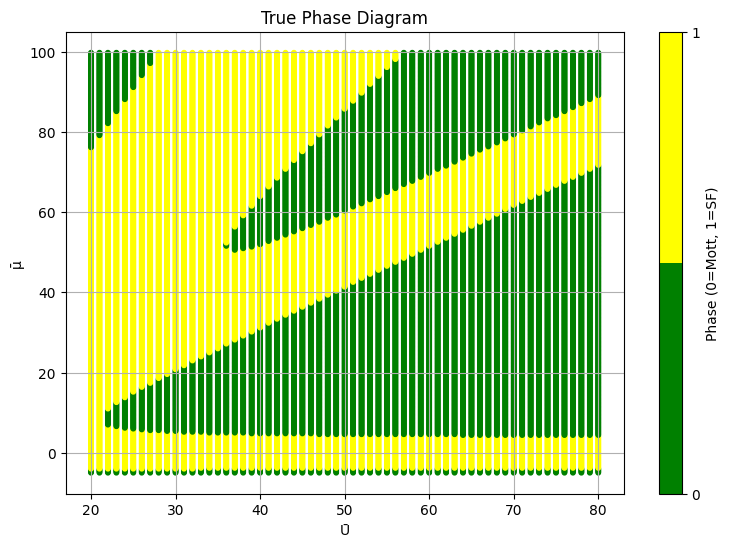

In [10]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(20.0-80.0)-(1.0)_Mu(-5.0-100.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(5.0-20.0)-(1.0)_Mu(-1.2-25.0)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# 20<u<120 and mu<120

In [11]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = 0.0, 50.0, 0.1


U_min, U_max, dU = 20.0, 120.0, 1.0   # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 120.0, 0.2
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min/4, U_max/4, dU,mu_min/4,  mu_max/4, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  


✅ Saved results to 4site_phase_tx1.0_U(5.0-30.0)-(1.0)_Mu(-1.2-30.0)-(0.2).csv and 4site_phase_tx1.0_U(20.0-120.0)-(1.0)_Mu(-5.0-120.0)-(0.2).npz


['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  20.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  20.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  20.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  20.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  20.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  20.0 -5.0      0
1  20.0 -4.8      0
2  20.0 -4.6      0
3  20.0 -4.4      0
4  20.0 -4.2      0


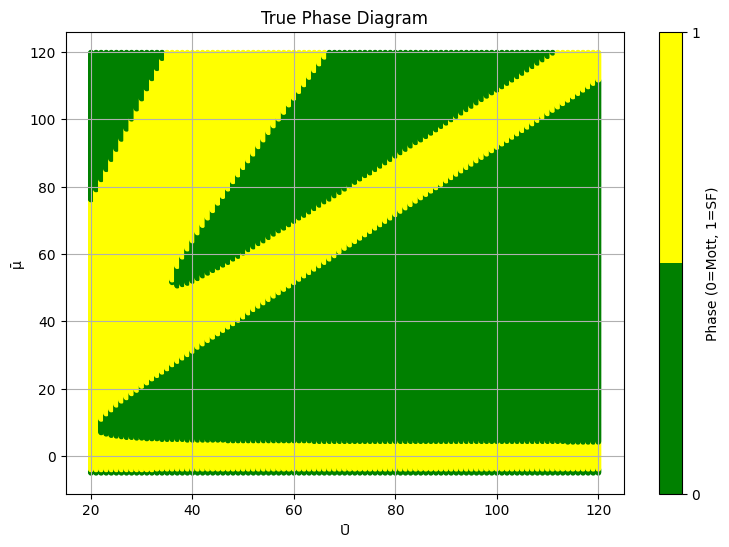

In [1]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(20.0-120.0)-(1.0)_Mu(-5.0-120.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(5.0-30.0)-(1.0)_Mu(-1.2-30.0)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# 20<u<150 and mu<150

In [2]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = 0.0, 50.0, 0.1


U_min, U_max, dU = 15.0, 150.0, 1.0   # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 150.0, 0.2
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min/4, U_max/4, dU,mu_min/4,  mu_max/4, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19870490572874383s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]


✅ Saved results to 4site_phase_tx1.0_U(3.8-37.5)-(1.0)_Mu(-1.2-37.5)-(0.2).csv and 4site_phase_tx1.0_U(15.0-150.0)-(1.0)_Mu(-5.0-150.0)-(0.2).npz


['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  15.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  15.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  15.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  15.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  15.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  15.0 -5.0      0
1  15.0 -4.8      0
2  15.0 -4.6      0
3  15.0 -4.4      0
4  15.0 -4.2      0


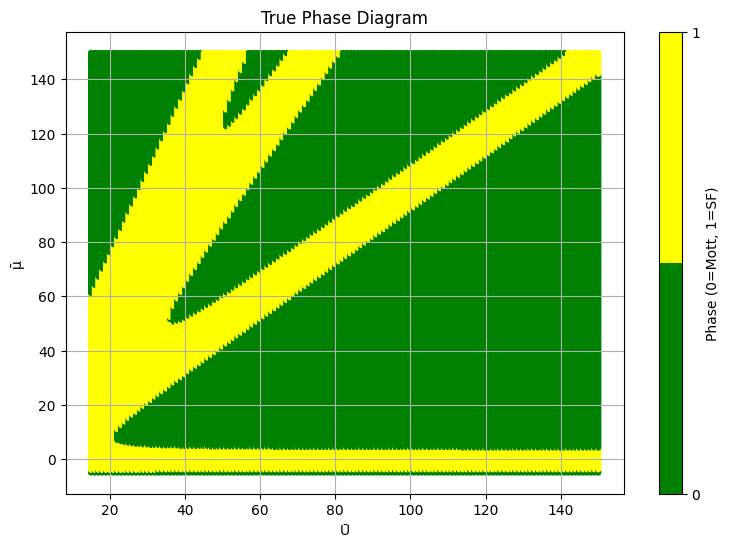

In [3]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(15.0-150.0)-(1.0)_Mu(-5.0-150.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(3.8-37.5)-(1.0)_Mu(-1.2-37.5)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# Generating another dataset With u=60 and mu=140

In [ ]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = 0.0, 50.0, 0.1


U_min, U_max, dU = 15.0, 60.0, 1.0   # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 150.0, 0.2
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min, U_max, dU,mu_min,  mu_max, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  15.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  15.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  15.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  15.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  15.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  15.0 -5.0      0
1  15.0 -4.8      0
2  15.0 -4.6      0
3  15.0 -4.4      0
4  15.0 -4.2      0


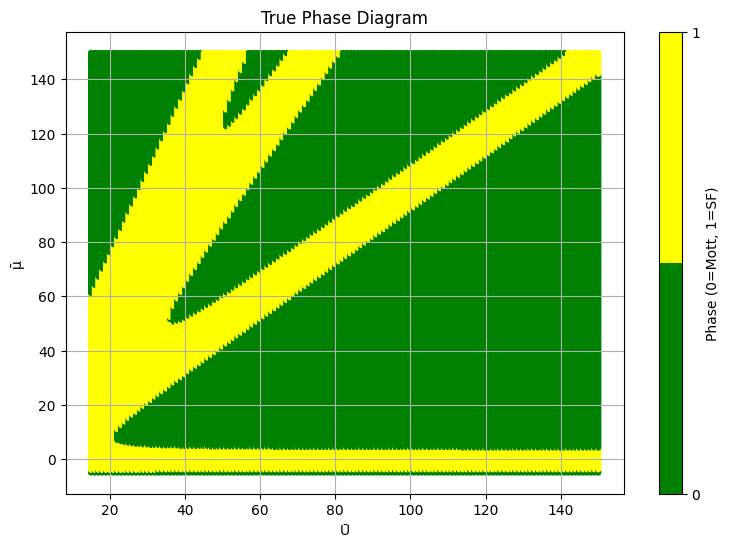

In [1]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(15.0-150.0)-(1.0)_Mu(-5.0-150.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(3.8-37.5)-(1.0)_Mu(-1.2-37.5)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Normalize before plotting
z, t = 4, 1.0
df["Ubar"]  = df["U"] / (z*t)
df["Mubar"] = df["mu"] / (z*t)

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["U"], df["mu"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



# Datsest with u<60 and mu<140 but each with step size size 0.1

In [ ]:
# ====== Cluster Mean-Field Bose-Hubbard (2x2 plaquette) ======
# Working code, last touched on 22-Oct-2020

import numpy as np
import math
from math import sqrt, factorial
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.linalg import eigsh   # iterative sparse eigensolver
from scipy.linalg import eigh           # dense solver (not really used here)

# >>> storage additions >>>
import csv
from pathlib import Path
from joblib import Parallel, delayed
import os

# <<< storage additions <<<

# --------------------------------------------------------------
# PRECOMPUTED SQUARE ROOTS OF PRIMES
# --------------------------------------------------------------
primesqt = np.array([
    1.41421356, 1.73205080, 2.23606797, 2.64575131, 3.31662479,
    3.60555127, 4.12310562, 4.35889894, 4.79583152, 5.38516480,
    5.56776436, 6.08276253, 6.40312423, 6.55743852, 6.85565460,
    7.28010988, 7.68114574, 7.81024967, 8.18535277, 8.42614977,
    8.54400374, 8.88819441, 9.11043357, 9.43398113, 9.84885780,
    10.04987562, 10.14889156, 10.34408043, 10.44030650, 10.63014581,
    11.26942766, 11.44552314, 11.70469991, 11.78982612, 12.20655561,
    12.28820572, 12.52996408, 12.76714533, 12.92284798, 13.15294643,
    13.37908816, 13.45362404, 13.82027496, 13.89244398, 14.03566884,
    14.10673597, 14.52583904, 14.93318452, 15.06651917, 15.13274595
])

# --------------------------------------------------------------
# PHYSICAL PARAMETERS
# --------------------------------------------------------------
tx = 1.0   # hopping in x
ty = 1.0   # hopping in y
# U  = 25.0  # on-site interaction strength

# # Instead of fixed U, we define a sweep
# U_min, U_max, dU = 0.0, 25.0, 0.01  # <-- choose your U range + step

# # chemical potential scan
# mu_min, mu_max, dmu = 0.0, 50.0, 0.1

U_min, U_max, dU = 15.0, 60.0, 0.1  # <-- choose your U range + step

# chemical potential scan
mu_min, mu_max, dmu = -5.0, 150.0, 0.1
# cluster geometry (2x2 plaquette)
xlen, ylen = 2, 2
m = xlen * ylen   # total number of sites = 4

nmax = 4          # maximum occupation per site

# Hilbert space dimension:
dim = (nmax+1)**m


def get_filename(tx, U_start, U_end, U_step, mu_start, mu_end, mu_step, suffix):
    """
    Generate a compact filename for the 2x2 cluster results.

    Example:
    phase_tx1.0_U(0.0-25.0)-(1.0)_Mu(0.0-40.0)-(0.2).csv
    """
    return (
        f"4site_phase_tx{tx:.1f}_"
        f"U({U_start:.1f}-{U_end:.1f})-({U_step})_"
        f"Mu({mu_start:.1f}-{mu_end:.1f})-({mu_step})"
        f"{suffix}"
    )


# --------------------------------------------------------------
# BASIS GENERATION
# --------------------------------------------------------------
def basis_gen(n, k, min_elem, max_elem):
    allowed = range(max_elem, min_elem-1, -1)
    def helper(n, k, t):
        if k == 0:
            if n == 0:
                yield t
        elif k == 1:
            if n in allowed:
                yield t + (n,)
        elif min_elem * k <= n <= max_elem * k:
            for v in allowed:
                yield from helper(n - v, k - 1, t + (v,))
    return helper(n, k, ())

# --------------------------------------------------------------
# Binary search lookup
# --------------------------------------------------------------
def BinarySearch(lys, val):  
    first, last, index = 0, len(lys)-1, -1
    while (first <= last) and (index == -1):
        mid = (first+last)//2
        if lys[mid] == val:
            index = mid
        elif val < lys[mid]:
            last = mid -1
        else:
            first = mid +1
    return index

# --------------------------------------------------------------
# LATTICE STRUCTURE: 2x2 PLAQUETTE
# --------------------------------------------------------------
lattice = np.zeros((ylen,xlen),int)
lat_ind = 0
for yy in range(ylen):
    for xx in range(xlen):
        lattice[yy][xx] = lat_ind
        lat_ind += 1

row_pair = []
for yy in range(ylen):
    for xx in range(xlen-1):
        row_pair.append([lattice[yy][xx], lattice[yy][xx+1]])

col_pair = []
for xx in range(xlen):
    for yy in range(ylen-1):
        col_pair.append([lattice[yy][xx], lattice[yy+1][xx]])

# --------------------------------------------------------------
# BOUNDARY SITES
# --------------------------------------------------------------
lbs = [xlen * x for x in range(0, ylen)]
rbs = [(xlen * (x+1))-1 for x in range(0, ylen)]
tbs = [x for x in range(lbs[0], rbs[0]+1)]
bbs = [x for x in range(lbs[-1], rbs[-1]+1)]
all_bs = list(set().union(lbs, rbs, tbs, bbs))
lr_zip = list(zip(lbs, rbs))
tb_zip = list(zip(tbs, bbs))
bds = lr_zip + tb_zip
nds = len(all_bs)

# --------------------------------------------------------------
# BASIS CONSTRUCTION
# --------------------------------------------------------------
a = []
for n in range(0, (nmax*m)+1):
    for x in basis_gen(n, m, 0, nmax):
        a.append(x)
bscount = len(a)

T = np.zeros(dim)
for ii in range(dim):
    for jj in range(m):
        T[ii] += primesqt[jj]*float(a[ii][jj])

ind = np.argsort(T)
T   = sorted(T)

# --------------------------------------------------------------
# OPERATOR MATRICES
# --------------------------------------------------------------
a_mat_dic = {}
for ii in all_bs:
    row, col, val = [], [], []
    for vv in range(dim):
        Tg = 0
        if a[vv][ii]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiD = sqrt(float(ket[ii]+1.0))
            ket[ii] = ket[ii]+1
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiD)
    a_mat = (coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()).getH()
    a_mat_dic[ii] = a_mat

n_mat_dic = {}
for ii in range(m):
    row, col, val = [], [], []
    for vv in range(dim):
        if a[vv][ii] > 0:
            ket = np.copy(a[vv])
            diag = float(ket[ii])
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(diag)
    n_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
    n_mat_dic[ii] = n_mat

# --------------------------------------------------------------
# HOPPING TERM (exact inside cluster)
# --------------------------------------------------------------
row, col, val = [], [], []
for ii in row_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -tx*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

for ii in col_pair:
    for vv in range(dim):
        if a[vv][ii[1]] >= 1.0 and a[vv][ii[0]]+1 < nmax+1:
            ket = np.copy(a[vv])
            aiDaj = -ty*sqrt(float((ket[ii[0]]+1.0)*ket[ii[1]]))
            ket[ii[0]] += 1; ket[ii[1]] -= 1
            Tg = 0
            for jj in range(m):
                Tg += float((primesqt[jj])*ket[jj])
            location = BinarySearch(T, Tg)
            uu = ind[location]
            row.append(uu); col.append(vv); val.append(aiDaj)

hop_mat = coo_matrix((val, (row, col)), shape=(dim, dim)).tocsr()
hop_mat = hop_mat + hop_mat.getH()

# --------------------------------------------------------------
# SELF-CONSISTENT MEAN FIELD LOOP
# --------------------------------------------------------------
phi, phi_new, diff, accuracy = {}, {}, {}, {}
gs = np.zeros(dim, dtype='float64')
for bsi in all_bs:
    accuracy[bsi] = 1e-6

phi_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
psq_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()
int_mat = coo_matrix((dim, dim), dtype=np.double).tocsr()

# >>> storage additions >>>
results = []
# <<< storage additions <<<

#np.arange(start, stop, step) goes up to but not including stop.
#So if you write
# --- Parallel sweep over (U, mu) ---------------------------------------------

# Build grids (inclusive of endpoints, like your current arange + d step)
U_vals  = np.arange(U_min, U_max + dU, dU)
mu_vals = np.arange(mu_min, mu_max, dmu)

def solve_point(U, mu):
    """
    Self-consistent mean-field solve for a single (U, mu).
    Uses read-only globals: a_mat_dic, n_mat_dic, hop_mat, etc.
    Creates fresh local dicts to avoid race conditions.
    Returns one results row.
    """
    phi, phi_new, diff = {}, {}, {}
    for bsi in all_bs:
        phi[bsi] = 0.0
        phi_new[bsi] = 0.3
        diff[bsi] = abs(phi[bsi] - phi_new[bsi])

    iteration = 0
    # local working matrices (start as zeros)
    phi_mat = 0.0
    psq_mat = 0.0
    int_mat = 0.0

    while all(diff[bsi] > accuracy[bsi] for bsi in all_bs):
        H_mat = 0.0
        phi_mat = 0.0
        psq_mat = 0.0
        int_mat = 0.0

        # update phi from last iteration
        for bsi in all_bs:
            phi[bsi] = phi_new[bsi]

        # mean-field boundary couplings
        for xx in lr_zip:
            phi_mat += - tx*phi[xx[0]]*(a_mat_dic[xx[1]].getH() + a_mat_dic[xx[1]])
            phi_mat += - tx*phi[xx[1]]*(a_mat_dic[xx[0]].getH() + a_mat_dic[xx[0]])
            psq_mat += + 2.0*tx*phi[xx[0]]*phi[xx[1]]*eye(dim, dtype=np.double, format='csr')
        for yy in tb_zip:
            phi_mat += - ty*phi[yy[0]]*(a_mat_dic[yy[1]].getH() + a_mat_dic[yy[1]])
            phi_mat += - ty*phi[yy[1]]*(a_mat_dic[yy[0]].getH() + a_mat_dic[yy[0]])
            psq_mat += + 2.0*ty*phi[yy[0]]*phi[yy[1]]*eye(dim, dtype=np.double, format='csr')

        # on-site interaction + chemical potential
        for ii in range(m):
            int_mat += (U/2.0)*n_mat_dic[ii]*(n_mat_dic[ii]-eye(dim, dtype=np.double, format='csr'))
            int_mat += - mu*n_mat_dic[ii]

        H_mat = hop_mat + int_mat + psq_mat + phi_mat

        nev = min(dim, 3)
        if nev == 1:
            eigenvalues = H_mat[0, 0]
            eigenvectors = eye(dim, dtype=np.double, format='csr')
        else:
            eigenvalues, eigenvectors = eigsh(H_mat, k=3, which='SA')

        gs = eigenvectors[:, 0]

        for bsi in all_bs:
            phi_new[bsi] = gs.transpose().dot(a_mat_dic[bsi].dot(gs))
            diff[bsi] = abs(phi[bsi] - phi_new[bsi])

        iteration += 1
        if iteration > 10000:
            break

    rho = {}
    for bsi in all_bs:
        rho[bsi] = gs.transpose().dot(n_mat_dic[bsi].dot(gs))

    # print line (optional; printing from parallel workers can be noisy)
    # print(f"{tx:3.2f} {U:6.2f} {mu:6.2f} "
    #       f"{rho[0]:8.4f} {rho[1]:8.4f} {rho[2]:8.4f} {rho[3]:8.4f} "
    #       f"{phi_new[0]**2:8.4f} {phi_new[1]**2:8.4f} {phi_new[2]**2:8.4f} {phi_new[3]**2:8.4f} "
    #       f"{eigenvalues[0]:12.6f} {iteration:6d}")

    return [
        round(tx, 2), round(U, 2), round(mu, 2),
        round(rho[0], 4), round(rho[1], 4), round(rho[2], 4), round(rho[3], 4),
        round(phi_new[0]**2, 4), round(phi_new[1]**2, 4), round(phi_new[2]**2, 4), round(phi_new[3]**2, 4),
        round(float(eigenvalues[0]), 6), int(iteration)
    ]

# Optional: prevent BLAS oversubscription inside each process
os.environ.setdefault("OMP_NUM_THREADS", "1")

# Run grid in parallel
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(solve_point)(U, mu)
    for U in U_vals
    for mu in mu_vals
)

# Keep rows ordered (U major, then mu)
results.sort(key=lambda r: (r[1], r[2]))

# --- Save CSV/NPZ with dynamic filenames ------------------------------------
csv_name = get_filename(tx,U_min/4, U_max/4, dU,mu_min/4,  mu_max/4, dmu, ".csv")
npz_name = get_filename(tx,U_min, U_max, dU,mu_min, mu_max, dmu, ".npz")


# --- Save CSV/NPZ exactly like before ----------------------------------------
headers = [
    "tx","U","mu",
    "rho0","rho1","rho2","rho3",
    "phi0_sq","phi1_sq","phi2_sq","phi3_sq",
    "E0","iters"
]
out_csv = Path(csv_name)
with out_csv.open("w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(results)

# Save NPZ
np.savez_compressed(
    npz_name,
    headers=np.array(headers, dtype=object),
    data=np.array(results, dtype=float)
)

print(f"\n✅ Saved results to {csv_name} and {npz_name}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  